In [5]:
pip install causal-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

import pandas as pd

df_train = pd.read_csv('C:/Users/ACER/Documents/causal/csuite_mixed_confounding/train.csv')
df_test = pd.read_csv('C:/Users/ACER/Documents/causal/csuite_mixed_confounding/test.csv')

['1.26.4', '2.2.3', '0.20.3', '1.9.0']


In [2]:
from causallearn.search.FCMBased import lingam
model = lingam.VARLiNGAM()
model.fit(df_train)
model.fit(df_test)

print(model.causal_order_)
print(model.adjacency_matrices_[0])
print(model.adjacency_matrices_[1])
print(model.residuals_)

[7, 0, 2, 9, 5, 4, 6, 3, 10, 1, 11, 8]
[[ 0.     0.     0.     0.     0.     0.     0.     0.074  0.     0.
   0.     0.   ]
 [ 1.004  0.    -0.376 -0.375 -0.358  0.     0.     0.346  0.     0.
  -0.106  0.   ]
 [ 0.661  0.     0.     0.     0.     0.     0.     0.056  0.     0.
   0.     0.   ]
 [ 1.251  0.    -0.253  0.    -0.291 -0.249 -0.208  0.     0.     0.
   0.     0.   ]
 [ 0.226  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.652  0.     0.     0.     0.     0.     0.     0.076  0.    -0.037
   0.     0.   ]
 [ 1.01   0.    -0.19   0.    -0.158 -0.205  0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [-0.713  0.592  0.205  0.242  0.249  0.081  0.    -0.199  0.     0.
   0.     0.   ]
 [ 0.825  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.961 -0.

In [27]:
true_graph = model.adjacency_matrices_[0]
estimated_graph = model.adjacency_matrices_[1]

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to compute SHD
def compute_shd(true_graph, estimated_graph):
    if true_graph.shape != estimated_graph.shape:
        raise ValueError("The shapes of true_graph and estimated_graph must be the same.")
        
    added_edges = np.sum((estimated_graph - true_graph) == 1)
    removed_edges = np.sum((estimated_graph - true_graph) == -1)
    return added_edges + removed_edges

# Function to compute SID
def compute_sid(true_graph, estimated_graph):
    if true_graph.shape != estimated_graph.shape:
        raise ValueError("The shapes of true_graph and estimated_graph must be the same.")
        
    true_edges = (true_graph != 0).astype(int)
    estimated_edges = (estimated_graph != 0).astype(int)
    return np.sum(np.abs(true_edges - estimated_edges))

# Function to compute FDR
def compute_fdr(true_graph, estimated_graph):
    if true_graph.shape != estimated_graph.shape:
        raise ValueError("The shapes of true_graph and estimated_graph must be the same.")
        
    tp = np.sum((true_graph == 1) & (estimated_graph == 1))  # True Positives
    fp = np.sum((true_graph == 0) & (estimated_graph == 1))  # False Positives
    return fp / (tp + fp) if (tp + fp) > 0 else 0

# Function to compute MCC
def compute_mcc(true_graph, estimated_graph):
    if true_graph.shape != estimated_graph.shape:
        raise ValueError("The shapes of true_graph and estimated_graph must be the same.")
        
    # Flatten the matrices for binary classification
    y_true = (true_graph != 0).flatten()
    y_pred = (estimated_graph != 0).flatten()
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) > 0 else 0
    return mcc


shd = compute_shd(true_graph, estimated_graph)
sid = compute_sid(true_graph, estimated_graph)
fdr = compute_fdr(true_graph, estimated_graph)
mcc = compute_mcc(true_graph, estimated_graph)

print("SHD:", shd)
print("SID:", sid)
print("FDR:", fdr)
print("MCC:", mcc)


SHD: 0
SID: 106
FDR: 0
MCC: 0


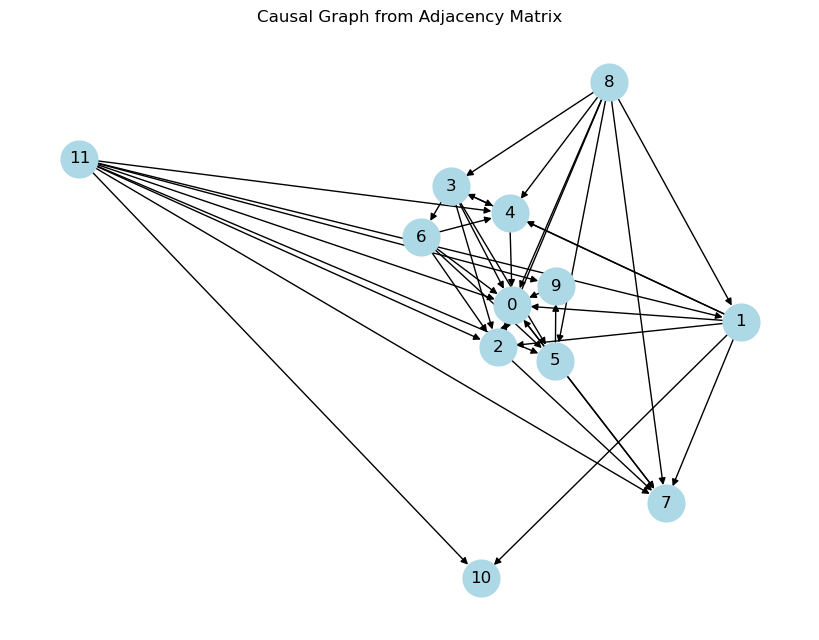

In [31]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph from the adjacency matrix
G = nx.from_numpy_matrix(true_graph, create_using=nx.DiGraph)

# Visualize the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Position nodes using spring layout
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', arrows=True)
plt.title("Causal Graph from Adjacency Matrix")
plt.show()